In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/')

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import preprocessing
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import csv
import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

In [2]:
#running on a windows machine, change filepaths as needed

train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
print "Number of categories: {}".format(len(train_df.Category.unique()))
print "Summary of X"
print train_df.X.describe()
print "Summary of Y"
print train_df.Y.describe()

Number of categories: 39
Summary of X
count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64
Summary of Y
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64


In [4]:
# Feature Names: address, dayofweek
le = preprocessing.LabelEncoder()
dow = le.fit_transform(train_df.DayOfWeek.values)
dow_orig = le.classes_
addr = le.fit_transform(train_df.Address)
addr_orig = le.classes_
category = le.fit_transform(train_df.Category)
cat_orig = le.classes_
pdist = le.fit_transform(train_df.PdDistrict)
pd_orig = le.classes_

In [5]:
train_df['crime'] = category
train_df['addr'] = addr
train_df['dow'] = dow
train_df['pd'] = pdist

In [6]:
dates = pd.DatetimeIndex(train_df.Dates)

In [7]:
train_df['date'] = dates.date
train_df['time'] = dates.time
train_df['hour'] = dates.hour
train_df['minutes'] = dates.minute
train_df['month'] = dates.month
train_df['woy'] = dates.weekofyear

train_df.ix[train_df.hour <12,'time_of_day'] = "morning"
train_df.ix[train_df.hour >=12,'time_of_day'] = "midday"
train_df.ix[train_df.hour >14,'time_of_day'] = "afternoon"
train_df.ix[train_df.hour >18,'time_of_day'] = "night"

le = preprocessing.LabelEncoder()
tod = le.fit_transform(train_df.time_of_day.values)
tod_orig = le.classes_

train_df['tod'] = tod

# Season
train_df.ix[train_df.month == 12,'seas'] = "winter"
train_df.ix[train_df.month == 1,'seas'] = "winter"
train_df.ix[train_df.month == 2,'seas'] = "winter"
train_df.ix[train_df.month == 3,'seas'] = "spring"
train_df.ix[train_df.month == 4,'seas'] = "spring"
train_df.ix[train_df.month == 5,'seas'] = "spring"
train_df.ix[train_df.month == 6,'seas'] = "summer"
train_df.ix[train_df.month == 7,'seas'] = "summer"
train_df.ix[train_df.month == 8,'seas'] = "summer"
train_df.ix[train_df.month == 9,'seas'] = "fall"
train_df.ix[train_df.month == 10,'seas'] = "fall"
train_df.ix[train_df.month == 11,'seas'] = "fall"

le = preprocessing.LabelEncoder()
season = le.fit_transform(train_df.seas.values)
season_orig = le.classes_

train_df['season'] = season

In [14]:
train_df_new = train_df[['date','month', 'woy', 'hour','minutes','time','tod', 'dow','season', 'pd','addr','X','Y','crime']]
train_df_new.head()

,date,month,woy,hour,minutes,time,tod,dow,season,pd,addr,X,Y,crime
0,2015-05-13,5,20,23,53,23:53:00,3,6,1,4,19790,-122.425892,37.774599,37
1,2015-05-13,5,20,23,53,23:53:00,3,6,1,4,19790,-122.425892,37.774599,21
2,2015-05-13,5,20,23,33,23:33:00,3,6,1,4,22697,-122.424363,37.800414,21
3,2015-05-13,5,20,23,30,23:30:00,3,6,1,4,4266,-122.426995,37.800873,16
4,2015-05-13,5,20,23,30,23:30:00,3,6,1,5,1843,-122.438738,37.771541,16


In [17]:
# Split this into Dev and Training Data
DEV_SIZE = 0.20

# fix a random seed
np.random.seed(0)
# Create boolean mask
# np.random creates a vector of random values between 0 and 1
# Those values are filtered to create a binary mask
msk = np.random.rand(len(train_df_new)) < DEV_SIZE

dev = train_df_new[msk]
dev_labels = np.array(dev.crime)
dev.drop('crime',1,inplace=True)

train = train_df_new[~msk]  # inverse of boolean mask
train_labels = np.array(train.crime)
train.drop('crime',1,inplace=True)

print "Dev: " + str(dev.shape)
print "Train: " + str(train.shape)
#print "Test: " + str(test_df.shape)

/home/simon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/simon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Dev: (175399, 13)
Train: (702650, 13)


/home/simon/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


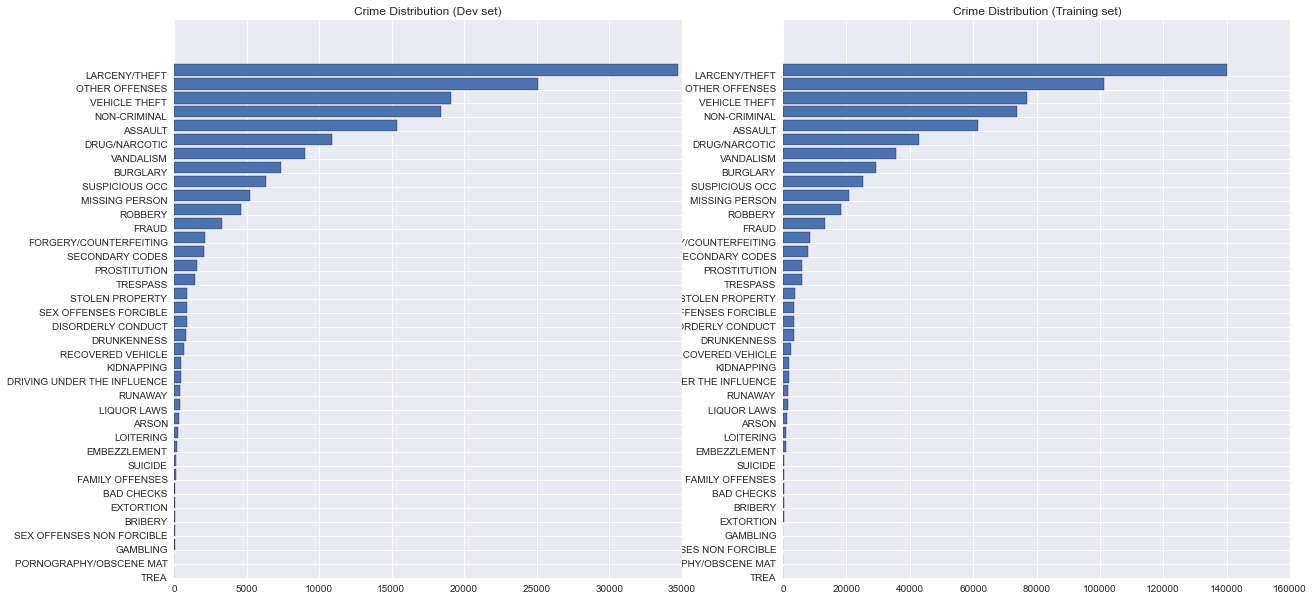

In [11]:
# make sure dev and train datasets have similar
# distribution for outcome variable
plt.figure(figsize=(20,10))
labels = [train_labels, dev_labels]
titles = ["Training set","Dev set"]
for i in [0,1]:
    plt.subplot(1,2,i)
    hist = np.histogram(labels[i], bins=range(38))
    ix = np.argsort(hist[0])
    plt.barh(range(37),hist[0][ix])
    x = plt.yticks(range(37),cat_orig[ix])
    ttl = "Crime Distribution ({})".format(titles[i])
    plt.title(ttl)

In [29]:
# convert training set to np array
train_data = np.array(train[['season','dow','pd','tod', 'woy', 'addr']])
dev_data = np.array(dev[['season', 'dow','pd','tod', 'woy', 'addr']])

# Gaussian NB
model = GaussianNB()
model.fit(train_data,train_labels)

preds = model.predict(dev_data)

In [25]:
accuracy = metrics.accuracy_score(dev_labels,preds)
print accuracy

0.203553041922


In [30]:
# K- Nearest Neighbors

neighbors = 1

knn = KNeighborsClassifier(neighbors)
start_time = time.time()
knn.fit(train_data, train_labels)
print 'Train time = %.2f' %(time.time() - start_time)
start_time = time.time()
accuracy = knn.score(dev_data, dev_labels)
print 'Accuracy = %.4f' %(accuracy)
print 'Prediction time = %.2f' %(time.time() - start_time)

Train time = 1.87
Accuracy = 0.2208
Prediction time = 1.63


In [31]:
# Decision Tree

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train_data, train_labels)

print 'Accuracy (a decision tree):', dt.score(dev_data, dev_labels)



Accuracy (a decision tree): 0.231363918836


In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print 'Accuracy (a random forest):', rfc.score(dev_data, dev_labels)


In [14]:

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train_data, train_labels)
print 'Accuracy (adaboost with decision trees):', abc.score(dev_data, dev_labels)

Accuracy (adaboost with decision trees): 0.208017149471
